# Bioinformatics Assignment 1

### Phylogenetic Tree Construction by Sequence-Based Distance

In this Jupyter NoteBook, required function definitions are provided to you. You are free to add different functions but I will be using these methods to test your code. 

#### Reading file

In [1]:
# Imports
import re

Read organisms.txt to a global dictionary. I also keep another one with name:sequence pairs

In [2]:
organisms = dict()
with open('organisms.txt') as f:
    text = f.read()

m_iter = re.finditer('(?<=\')[a-zA-Z0-9_ ]+(\.\w+)?', text)
while(True):
    try:
        gb_id = next(m_iter).group()
        name = next(m_iter).group()
        prot_seq = next(m_iter).group()
        organisms[gb_id] = [name, prot_seq]
    except StopIteration:
        break

byname = {}
for codename in organisms:
    name, seq = organisms[codename]
    byname[name.lower()] = seq

Method below pretty prints a 2d list for debugging

In [3]:
def pp(matrix):
    for row in matrix:
        print(*row, sep='\t')

Read blosum table to a global variable

In [4]:
with open('blosum62_ncbi.txt') as f:
    rev_index = {code.lower():i for i, code in enumerate(f.readline().split())}
    index = {}
    for line in f:
        code, *scores = line.split()
        index[code.lower()]  = [int(score) for score in scores]
        
        

A method for easy acces to the blosum table

In [5]:
def blosum_val(f,s):
    return index[f.lower()][rev_index[s.lower()]]

#### Algorithm implementation

2. Implement Needleman Wunsch algorithm using the [BLOSUM62](!https://www.ncbi.nlm.nih.gov/Class/FieldGuide/BLOSUM62.txt) substitution matrix.

In [6]:
def needleman_wunsch(seq1, seq2):
    seq1 = " " + seq1
    seq2 = " " + seq2
    l1 = len(seq1)
    l2 = len(seq2)
    matrix = [[0]*l2 for _ in range(l1)]

    indel = -1 #blosum_val('a','*')

    # init first row
    matrix[0] = [indel*i for i in range(l2)]


    # init first column
    for j in range(l1):
        matrix[j][0] = indel*j
        
    path = ""
    s1_best_alignment = ""
    s2_best_alignment = ""


    for i in range(1, l1):
        for j in range(1, l2):

            up = matrix[i-1][j] + indel
            left = matrix[i][j-1] + indel
            diagonal = matrix[i-1][j-1] + blosum_val(seq1[i],seq2[j])
            
            matrix[i][j] = max(up, left, diagonal)

    minus_inf = float('-inf')
    
    # back track
    i = l1-1
    j = l2-1
    while(i>0 or j>0): 
        up = matrix[i-1][j] if i - 1 >= 0 else minus_inf
        left = matrix[i][j-1] if j - 1 >= 0  else minus_inf
        diagonal = matrix[i-1][j-1] if i - 1 >= 0 and j - 1 >= 0 else minus_inf
        
        if diagonal >= up and diagonal >= left:
            s1_best_alignment = seq1[i] + s1_best_alignment
            s2_best_alignment = seq2[j] + s2_best_alignment
            path= 'D' + path
            i-=1
            j-=1
        elif i>0 and up >= left and up >= diagonal:
            s2_best_alignment = '-' + s2_best_alignment
            s1_best_alignment = seq1[i] + s1_best_alignment
            path= 'U' + path
            i-=1

        elif j>0 and left >= up  and left >= diagonal:
            s1_best_alignment = '-' + s1_best_alignment
            s2_best_alignment = seq2[j] + s2_best_alignment
            path= 'L' + path
            j-=1


        

#     print(path)
#     pp(matrix)
    best_alignment_score_needleman_wunsch = matrix[-1][-1]
    best_alignment_needleman_wunsch = s1_best_alignment + '<==>' + s2_best_alignment
    return best_alignment_score_needleman_wunsch, best_alignment_needleman_wunsch #, matrix, path
         


3. Implement Smith Waterman algorithm using the [BLOSUM62](!https://www.ncbi.nlm.nih.gov/Class/FieldGuide/BLOSUM62.txt) substitution matrix.

In [7]:
def smith_waterman(seq1, seq2):
    seq1 = " " + seq1
    seq2 = " " + seq2
    l1 = len(seq1)
    l2 = len(seq2)
    matrix = [[0]*l2 for _ in range(l1)]

    indel = -1 #blosum_val('a','*')

    # init first row
    matrix[0] = [indel*i for i in range(l2)]


    # init first column
    for j in range(l1):
        matrix[j][0] = indel*j
        

    for i in range(1, l1):
        for j in range(1, l2):
            up = matrix[i-1][j] + indel
            left = matrix[i][j-1] + indel
            diagonal = matrix[i-1][j-1] + blosum_val(seq1[i],seq2[j])
            free_ride = 0
            
            matrix[i][j] = max(up, left, diagonal, free_ride)

    minus_inf = float('-inf')
    
    # back track

    # find end of best local allignment
    max_ = float('-inf')
    winner = () # will hold end of local allignment
    for i in range(l1):
        for j in range(l2):
            if matrix[i][j] > max_:
                max_ = matrix[i][j]
                winner = (i, j)
    
    
    path = ""
    s1_best_alignment = ""
    s2_best_alignment = ""
    i = winner[0]
    j = winner[1]
    the_start = (i, j) # evantually will hold start of local allignment
    current = max_
    while(current > 0): #since we are seeking the 0, we might as well != 0
        
        
        up = matrix[i-1][j]
        left = matrix[i][j-1]
        diagonal = matrix[i-1][j-1]
        
        if diagonal >= left and diagonal >= up:
            s1_best_alignment = seq1[i] + s1_best_alignment
            s2_best_alignment = seq2[j] + s2_best_alignment
            path= 'D' + path
            i-=1
            j-=1
        elif up >= left and up >= diagonal:
            s2_best_alignment = '-' + s2_best_alignment
            s1_best_alignment = seq1[i] + s1_best_alignment
            path= 'U' + path
            i-=1
        elif left >= up and left >= diagonal:
            s1_best_alignment = '-' + s1_best_alignment
            s2_best_alignment = seq2[j] + s2_best_alignment
            path= 'L' + path
            j-=1
        
        the_start = (i, j)
        current = matrix[i][j]

        
#     print(winner)
#     print(the_start)
#     print(path)
#     pp(matrix)
    best_alignment_score_smith_waterman = matrix[winner[0]][winner[1]]
    best_alignment_smith_waterman =  s1_best_alignment + '<==>' + s2_best_alignment
    return best_alignment_score_smith_waterman, best_alignment_smith_waterman #, matrix
         


#### Calculate Score Matrix

4. Using Needleman Wunsch and Smith Waterman algorithms you will find the **scores**, i.e. similarities between any two sequences. Now, crete an NxN score matrix where N is the length of organisms dictionary and calculate the scores of each organism pairs.

In [8]:
def calculate_score_matrix(organisms, algorithm):
    # Calculate score matrix using smith_waterman() or needleman_wunsch()
    # algorithm is the calleble ie the function it self
    score_matrix = [[0]*len(organisms) for _ in range(len(organisms))]
    for i, org1 in enumerate((organisms)):
        for j, org2 in enumerate((organisms)):
            n1, seq1 = organisms[org1]
            n2, seq2 = organisms[org2]
            score, *rest= algorithm(seq1, seq2)
            score_matrix[i][j] = score          
            
    return score_matrix

#### Calculate Distance Matrix

5. Now, you will use the score matrices to calculate **distances** between organism pairs. To do that;
    1. Find the maximum values of the score matrices.
    2. Subtract the each element of these matrices from the corresponding maximum values.
    3. Store resulting NxN matrices.

Below is a helper method for using builtin max function on a 2D list 

In [9]:
def flatten(matrix):
    for row in matrix:
        yield from row

In [10]:
# Calculate the distances between organism pairs.
def calculate_distance_matrix(score_matrix):
    #  organisms and algorithm parameters were not needed
    
    max_ = max(flatten(score_matrix))
    N = len(score_matrix)
    distance_matrix = [[0]*N for _ in range(N)]
    for i in range(N):
        for j in range(N):
            distance_matrix[i][j] = max_ -  score_matrix[i][j]

    return distance_matrix

#### Generate Phylogenetic Tree

6. Finally, use below code to generate phylogenetic trees according to both Needleman Wunsch and Smith Waterman distance matrices.

In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram
import pylab

def generate_phylogenetic_tree(organisms, distance_matrix, method_name= "NW"):
    # i had to slightly change this function because 
    # it was using code names of the organisms as label instead of names (like 'KM096864.1' instead of 'chicken')
    average = linkage(distance_matrix, "average")
    dendrogram(average, labels=list(organisms[k][0] for k in (organisms.keys())), orientation="left", leaf_font_size=10)
    pylab.subplots_adjust(bottom=0.1, left=0.2, right=1.0, top=1.0)
    pylab.savefig("GirayEryilmaz_" + method_name +".jpg")


#### Function Calls

In [12]:

seq1 = organisms['EF153719.1'][1] # Turkey organism
seq2 = organisms['KM096864.1'][1] # Chicken organism

# Functions tests
best_alignment_score_needleman_wunsch, best_alignment_needleman_wunsch = needleman_wunsch(seq1, seq2)
print('needleman wunsch best alignment score:', best_alignment_score_needleman_wunsch)
nws1, nws2 = best_alignment_needleman_wunsch.split('<==>')
print(nws1)
print(nws2)



needleman wunsch best alignment score: 1366
MAHQAHSYHMVDPSPWPIFGAAAALLTTSGLIMWFHYNTST-LL-MAGLLSMLLVMLQWWRDVIRESTFQGHHTPTVQKGLRYGMILFITSEVFFFLGFFWAFFHSSLAPTPELGGQWPPTGINPLNPLDVPLLNTAILLASGVTVTWAHHSITEGNRKQAIHALTLTIAL-GLY-FTALQAMEYHETSFSIADSIYGSTFFVATGFHGLHVIIGSSFLTVCLLRLIKFHFT-SNHHFGFEAAAWYWHFVDIVWLFLYMSMYWWGSC
MAHQAHSYHMVDPSPWPIFGAAAALLTTSGLIMWFHYSS-TTLLTMG-LLSMLLVMLQWWRDVVRESTFQGHHTPTVQKGLRYGMILFITSEAFFFLGFFWAFFHSSLAPTPELGGQWPPTGVKPLNPLEVPLLNTAILLASGVTVTWAHHSITEGNRKQAIHALTLTI-LLGF-YFTALQAMEYHEASFSIADSVYGSTFFVATGFHGLHVIIGSSFLTVCLLRLIKFHFTPN-HHFGFEAAAWYWHFVDIIWLFLYMSMYWWGS-


In [13]:

best_alignment_score_smith_waterman, best_alignment_smith_waterman = smith_waterman(seq1, seq2)
print('smith waterman best allignment score', best_alignment_score_smith_waterman)
sws1, sws2 = best_alignment_smith_waterman.split('<==>')
print(sws1)
print(sws2)

smith waterman best allignment score 1367
MAHQAHSYHMVDPSPWPIFGAAAALLTTSGLIMWFHYNTST-LL-MAGLLSMLLVMLQWWRDVIRESTFQGHHTPTVQKGLRYGMILFITSEVFFFLGFFWAFFHSSLAPTPELGGQWPPTGINPLNPLDVPLLNTAILLASGVTVTWAHHSITEGNRKQAIHALTLTIAL-GLY-FTALQAMEYHETSFSIADSIYGSTFFVATGFHGLHVIIGSSFLTVCLLRLIKFHFT-SNHHFGFEAAAWYWHFVDIVWLFLYMSMYWWGS
MAHQAHSYHMVDPSPWPIFGAAAALLTTSGLIMWFHYSS-TTLLTMG-LLSMLLVMLQWWRDVVRESTFQGHHTPTVQKGLRYGMILFITSEAFFFLGFFWAFFHSSLAPTPELGGQWPPTGVKPLNPLEVPLLNTAILLASGVTVTWAHHSITEGNRKQAIHALTLTI-LLGF-YFTALQAMEYHEASFSIADSVYGSTFFVATGFHGLHVIIGSSFLTVCLLRLIKFHFTPN-HHFGFEAAAWYWHFVDIIWLFLYMSMYWWGS


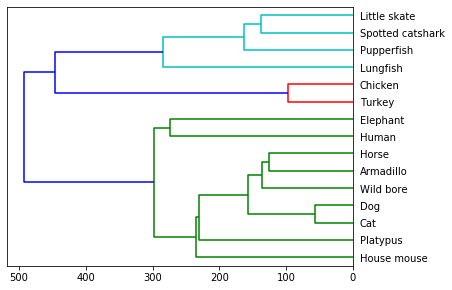

In [14]:
# Phylogenetic tree test
algorithm = needleman_wunsch
score_matrix = calculate_score_matrix(organisms, algorithm)
distance_matrix = calculate_distance_matrix(score_matrix)
generate_phylogenetic_tree(organisms, distance_matrix, "NW")

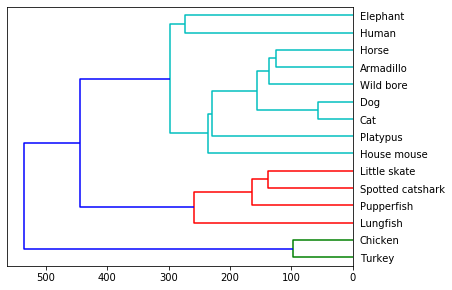

In [15]:
# Phylogenetic tree test
algorithm = smith_waterman
score_matrix = calculate_score_matrix(organisms, algorithm)
distance_matrix = calculate_distance_matrix(score_matrix)
generate_phylogenetic_tree(organisms, distance_matrix, "SW")

#### Comments

7. Comment on the results of two output images.

I believe my outputs are very reasonable.  Fish are together, chicken and turkey are closely related and mammals are also close together. Especially horse types. The smith - waterman and needleman - wunsch algorithms gave similar results but I believe this was to be expected as well. If the creatures are similar, both the best global alignment and the local alignment scores are high and they are both low when the creatures are dissimilar thus the graphs are similar.
Note: changing indel value aka gap penalty changes the results slightly.

Notes: 
1. Your are not allowed to use Numpy.
2. You are not allowed to use any libraries to find the Needleman Wunsch and Smith Waterman scores.
3. You can only use standard libraries apart from the given codes.
4. Please submit your assignment using Moodle. Upload a single zip file named as YourNameSurname.zip. Your zip file should include your report, your source code, and the corresponding read.me file. You can use any programming language of your choice. But, your read.me file should clearly explain how to run your program.
